First, we load the channels from Logdata. I picked these channels inspired by an Interview question I got at VCARB and only omitted the vertical accelerations because my team's models do not account for elevation changes yet.

Load MDF into Notebook

In [2]:
from asammdf import MDF
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from pathlib import Path

# Load MDF into the notebook
mdf_path = Path.cwd().parent / "data" / "AutoXFSG23" / "DataF009_2023-08-19_18-03-59.mdf"
mdf = MDF(mdf_path)

# Channel mapping (names chosen for this analysis)
CH = {
    "long_acc":              "ACCEL_X",              # longitudinal acceleration [m/s²]
    "lat_acc":               "ACCEL_Y",              # lateral acceleration [m/s²]
    "brake_pressure":        "PB_Brakeforce",        # braking force [% or N]
    "throttle_pedal":        "PB_Torque",            # engine torque or pedal proxy
    "car_speed":             "v_abs",                # absolute vehicle speed [m/s or km/h]
    "steering_wheel_angle":  "ECU_F_SteeringAngle",  # steering wheel angle [deg]
    "yaw_rate":              "yawrate",              # yaw rate [deg/s or rad/s]
    "pitch_rate":            "PITCH_ACC",            # pitch angular acceleration [deg/s²]
    "LAP_ID":                "Lapcounter"            # lap counter (only used for segmentation)
}


Align and Trim Data

In [3]:
import numpy as np
import pandas as pd

# Select channels to align on a common time grid
names = ["ACCEL_X","ACCEL_Y","PB_Brakeforce","PB_Torque",
         "v_abs","ECU_F_SteeringAngle","yawrate","PITCH_ACC"]

def pull_df(mdf, name):
    s = mdf.get(name)
    return pd.DataFrame({"time_s": s.timestamps, name: s.samples})

# Load all selected channels
dfs = [pull_df(mdf, n) for n in names]

# Combine timestamps and align using nearest-time merging
raw_time = np.unique(np.concatenate([d["time_s"].values for d in dfs]))
raw = pd.DataFrame({"time_s": raw_time})
for d in dfs:
    raw = pd.merge_asof(raw.sort_values("time_s"),
                        d.sort_values("time_s"),
                        on="time_s",
                        direction="nearest")

# Interpolate onto a constant time grid (e.g., 200 Hz)
fs = 200.0  # IMU sampling frequency
t = np.arange(raw.time_s.min(), raw.time_s.max(), 1.0/fs)
aligned = pd.DataFrame({"time_s": t})
for col in raw.columns:
    if col != "time_s":
        aligned[col] = np.interp(t, raw["time_s"].values, raw[col].values)

# Rough trimming: remove stationary sections at the beginning and end
v = aligned["v_abs"].values
moving = v > 3.0  # motion threshold in m/s
idx = np.flatnonzero(moving)

if len(idx):
    start = int(idx[0])
    end = int(idx[-1]) + 1
    aligned = aligned.iloc[start:end].reset_index(drop=True)
else:
    aligned = aligned.reset_index(drop=True)


Sanity Plots

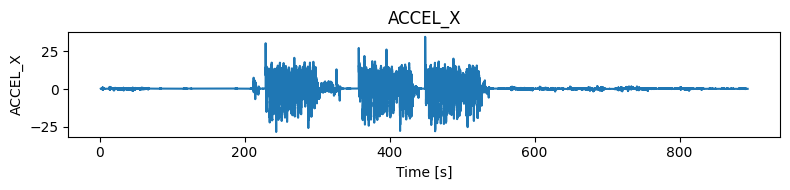

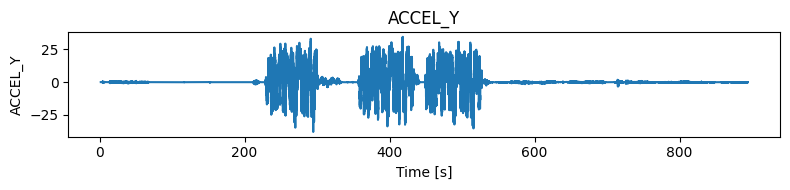

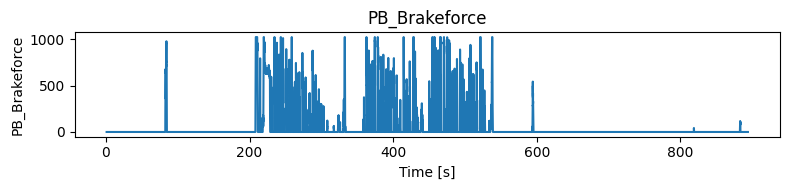

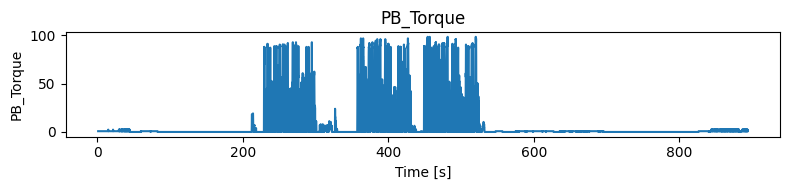

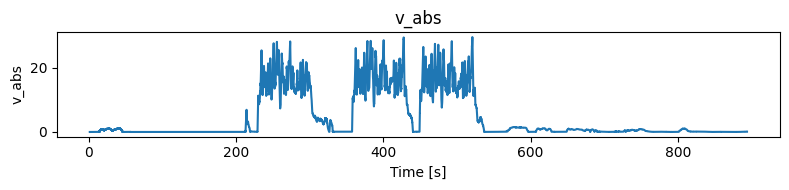

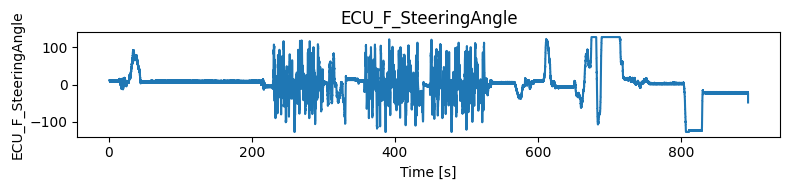

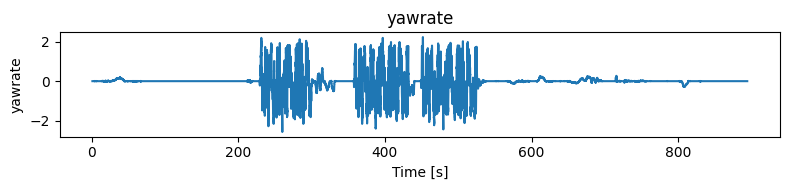

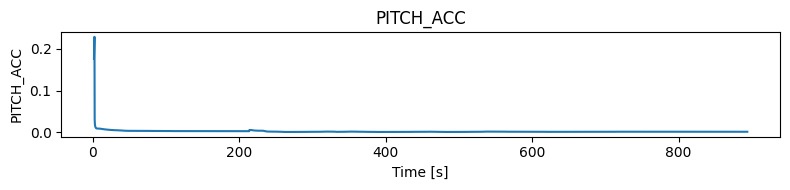

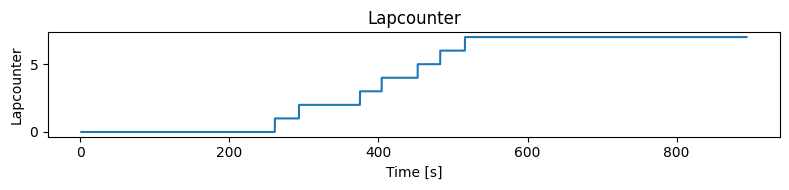

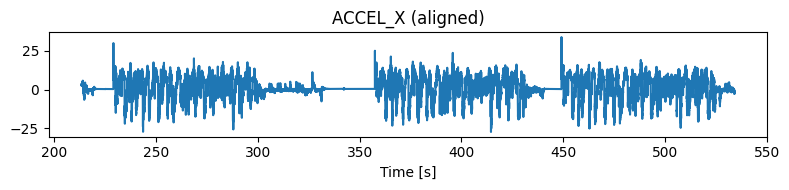

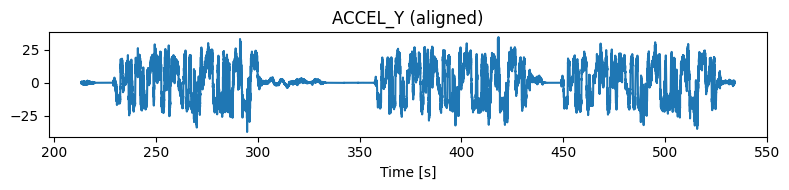

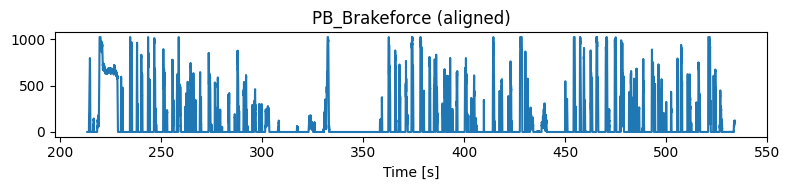

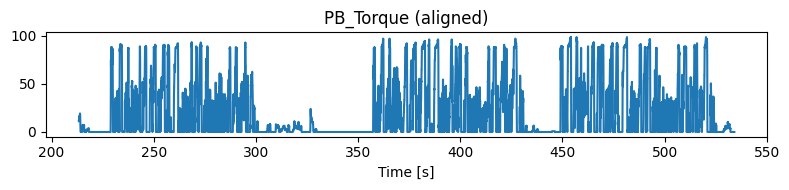

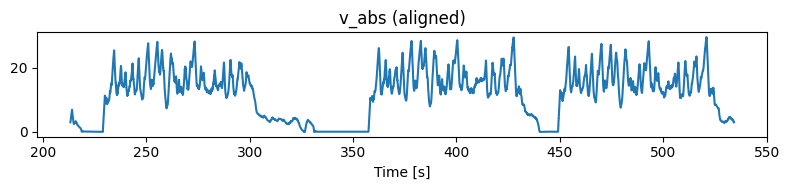

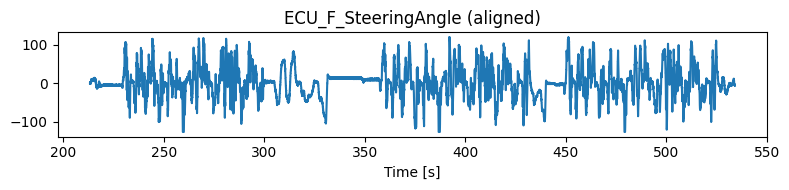

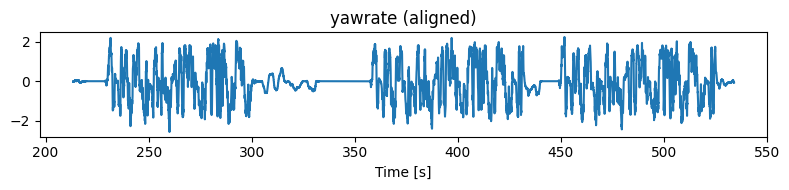

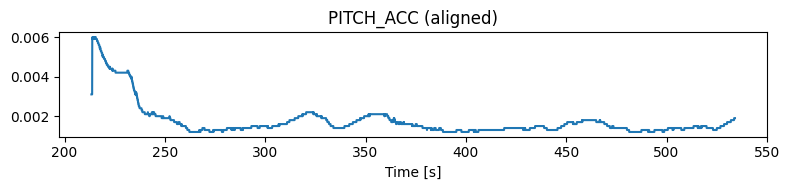

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def pull(mdf, ch):
    s = mdf.get(ch)
    return pd.DataFrame({"time_s": s.timestamps, "value": s.samples})

# Raw channels (direct from MDF)
for key, ch in CH.items():
    sig = pull(mdf, ch)
    plt.figure(figsize=(8,2))
    plt.plot(sig["time_s"], sig["value"])
    plt.title(f"{ch}")
    plt.xlabel("Time [s]")
    plt.ylabel(ch)
    plt.tight_layout()
    plt.show()

# Aligned and trimmed channels
for col in aligned.columns:
    if col == "time_s":
        continue
    plt.figure(figsize=(8,2))
    plt.plot(aligned["time_s"], aligned[col])
    plt.title(f"{col} (aligned)")
    plt.xlabel("Time [s]")
    plt.tight_layout()
    plt.show()


Smoothing and feature Engineering

In [5]:
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd

# Light smoothing to reduce sensor noise while preserving shape
def smooth(x, window=11, poly=2):
    w = int(window) if int(window)%2==1 else int(window)+1
    w = max(5, w)
    return savgol_filter(x, w, poly) if len(x) > w else x

df = aligned.copy()

# Smoothed base signals
df["Speed"]     = smooth(df["v_abs"])              # forward velocity
df["LongAcc"]   = smooth(df["ACCEL_X"])            # longitudinal acceleration (IMU)
df["LatAcc"]    = smooth(df["ACCEL_Y"])            # lateral acceleration (IMU)
df["Brake"]     = smooth(df["PB_Brakeforce"])      # driver braking input
df["Torque"]    = smooth(df["PB_Torque"])          # driver torque/throttle proxy
df["Steer"]     = smooth(df["ECU_F_SteeringAngle"])
df["YawRate"]   = smooth(df["yawrate"])
df["PitchAcc"]  = smooth(df["PITCH_ACC"])

# Derived features (rates of change and magnitudes)
dt = np.gradient(df["time_s"].values)
df["dSpeed_dt"] = np.gradient(df["Speed"].values) / np.where(dt==0, np.nan, dt)    # speed rate
df["dSteer_dt"] = np.gradient(df["Steer"].values) / np.where(dt==0, np.nan, dt)    # steering rate
df["SteerAbs"]  = np.abs(df["Steer"].values)                                        # steering magnitude

# Cleanup invalid values
df = df.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

# Compact feature matrix for ML
feature_cols = [
    "Speed",      # overall vehicle state
    "LongAcc",    # braking/accel via IMU
    "LatAcc",     # cornering load
    "Brake",      # braking input
    "Torque",     # drive input
    "SteerAbs",   # cornering intensity
    "dSpeed_dt",  # transitions in longitudinal state
    "dSteer_dt",  # transitions in steering
    "YawRate",    # rotational velocity
]
df_features = df[["time_s"] + feature_cols].copy()


Feature Scaling

In [6]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

scaler = StandardScaler()

# Build scaled feature matrix (time excluded)
X = df_features.drop(columns=["time_s"]).values
X_scaled = scaler.fit_transform(X)

# Store scaled features
df_scaled = df_features.copy()
df_scaled[df_features.columns[1:]] = X_scaled


Lap segmentation

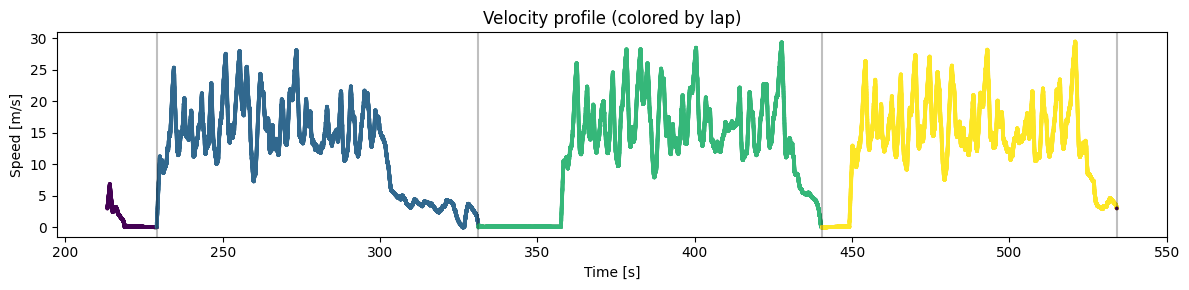

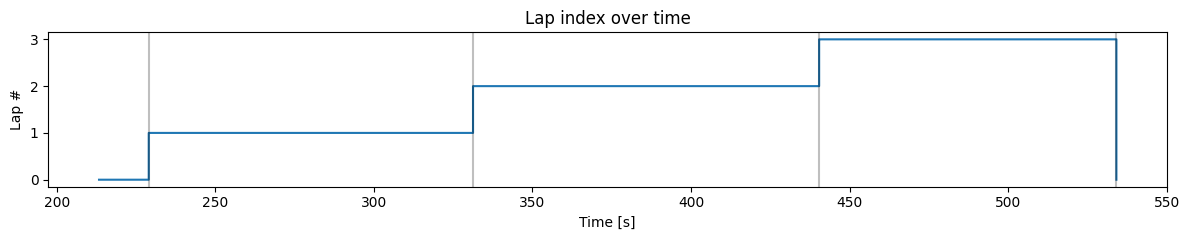

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Switch between LapCounter channel and heuristic
USELAPCOUNTER = 0
LAPTIME = 55  # expected lap time in seconds (for heuristic spacing)

t = aligned["time_s"].to_numpy()
speed = aligned["v_abs"].to_numpy()

if USELAPCOUNTER and "LapCounter" in aligned.columns:
    lap = aligned["LapCounter"].astype(int).to_numpy()
else:
    minima, _ = find_peaks(
        -speed,
        distance=int(LAPTIME / np.median(np.diff(t))),
        prominence=np.std(speed) * 0.3
    )
    bounds = np.r_[0, minima, len(speed) - 1]
    lap = np.zeros(len(speed), dtype=int)
    for i in range(len(bounds) - 1):
        lap[bounds[i]:bounds[i + 1]] = i

# Boundaries for visualization
bounds = np.where(np.diff(lap) != 0)[0] + 1

# Plot: speed colored by lap
plt.figure(figsize=(12,3))
plt.scatter(t, speed, c=lap, s=3)
for b in bounds:
    plt.axvline(t[b], color="k", alpha=0.25)
plt.xlabel("Time [s]")
plt.ylabel("Speed [m/s]")
plt.title("Velocity profile (colored by lap)")
plt.tight_layout()
plt.show()

# Plot: lap index over time
plt.figure(figsize=(12,2.5))
plt.step(t, lap, where="post", color="tab:blue")
for b in bounds:
    plt.axvline(t[b], color="k", alpha=0.25)
plt.xlabel("Time [s]")
plt.ylabel("Lap #")
plt.title("Lap index over time")
plt.tight_layout()
plt.show()


K Means CLustering and Visualization

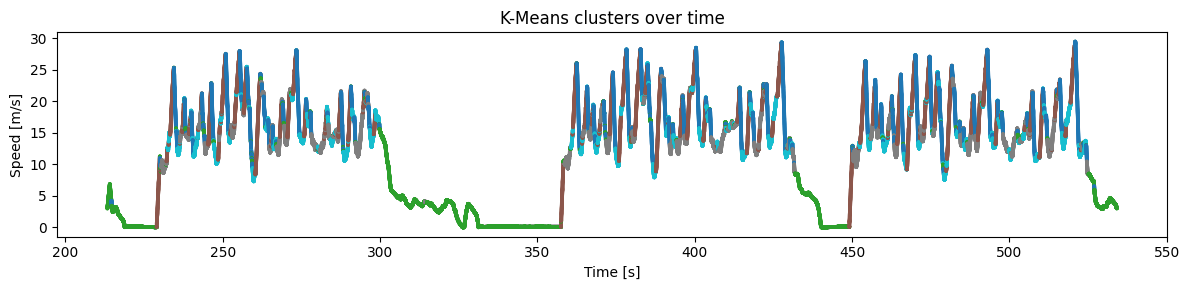

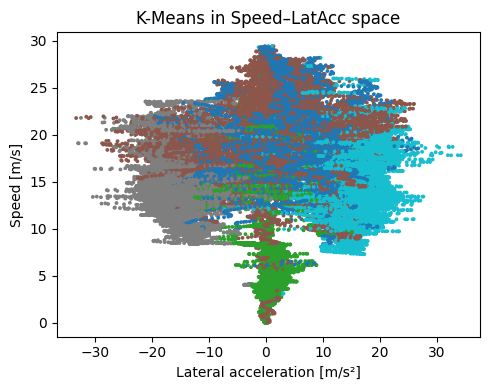

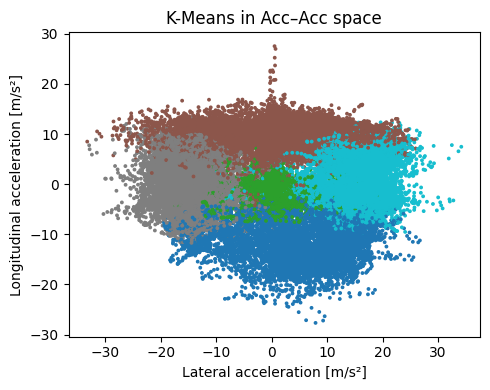

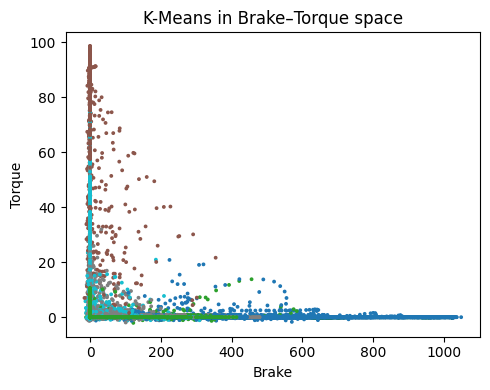

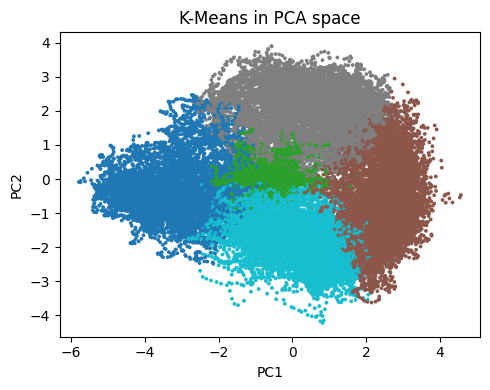

,Speed,LongAcc,LatAcc,Brake,Torque,SteerAbs,dSpeed_dt,dSteer_dt,YawRate
Cluster,,,,,,,,,
0,0.88,-1.88,0.35,1.99,-0.71,-0.45,-1.88,-0.13,-0.26
1,-1.15,-0.14,-0.02,-0.07,-0.66,-0.44,-0.07,-0.01,-0.02
2,0.91,1.31,0.02,-0.46,1.82,-0.59,1.32,-0.03,0.00
3,0.30,0.11,-1.43,-0.36,-0.04,1.00,0.08,-0.23,1.48
4,0.30,0.12,1.34,-0.38,-0.03,0.60,0.01,0.38,-1.40


In [9]:
# 7) K-Means clustering and visualizations
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

feature_cols = [
    "Speed", "LongAcc", "LatAcc", "Brake", "Torque",
    "SteerAbs", "dSpeed_dt", "dSteer_dt", "YawRate"
]
X = df_scaled[feature_cols].values

K = 5
km = KMeans(n_clusters=K, random_state=0, n_init="auto")
labels_km = km.fit_predict(X)

# Time series: speed coloured by cluster
plt.figure(figsize=(12,3))
plt.scatter(df_features["time_s"], df_features["Speed"], c=labels_km, s=3, cmap="tab10")
plt.xlabel("Time [s]")
plt.ylabel("Speed [m/s]")
plt.title("K-Means clusters over time")
plt.tight_layout()
plt.show()

# Feature space: Speed vs. Lateral Acceleration
plt.figure(figsize=(5,4))
plt.scatter(df_features["LatAcc"], df_features["Speed"], c=labels_km, s=3, cmap="tab10")
plt.xlabel("Lateral acceleration [m/s²]")
plt.ylabel("Speed [m/s]")
plt.title("K-Means in Speed–LatAcc space")
plt.tight_layout()
plt.show()

# Feature space: Lateral vs. Longitudinal Acceleration
plt.figure(figsize=(5,4))
plt.scatter(df_features["LatAcc"], df_features["LongAcc"], c=labels_km, s=3, cmap="tab10")
plt.xlabel("Lateral acceleration [m/s²]")
plt.ylabel("Longitudinal acceleration [m/s²]")
plt.title("K-Means in Acc–Acc space")
plt.tight_layout()
plt.show()

# Feature space: Brake vs. Torque
plt.figure(figsize=(5,4))
plt.scatter(df_features["Brake"], df_features["Torque"], c=labels_km, s=3, cmap="tab10")
plt.xlabel("Brake")
plt.ylabel("Torque")
plt.title("K-Means in Brake–Torque space")
plt.tight_layout()
plt.show()

# PCA projection (2D) for overview
pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X)
plt.figure(figsize=(5,4))
plt.scatter(Z[:,0], Z[:,1], c=labels_km, s=3, cmap="tab10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means in PCA space")
plt.tight_layout()
plt.show()

# Cluster profile (means per cluster, in scaled feature space)
cluster_profile = (
    pd.DataFrame(X, columns=feature_cols)
    .assign(Cluster=labels_km)
    .groupby("Cluster").mean().round(2)
)
cluster_profile


In [ ]:
TODO:
1. Interpretieren, K CLustering verstehen
2. PLots über Strecke/Koordinaten?
3. GMM Clustering
4. Vergleich einzelner Fahrer/Rundencharacteristik